# Лабораторная работа 6
## 1. Выбор начальных условий
### а. Набор данных

Был выбран датасет классификации предмета по изображению, а точнее пистолетов и ножей. Данный датасет может быть полезен для охотничьих маркетплейсов, в которых требуется анализ пользователей. https://www.kaggle.com/datasets/leventoz/knife-vs-pistol

In [1]:
import kagglehub
path = kagglehub.dataset_download("leventoz/knife-vs-pistol")
print(path)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/denisfadeev/.cache/kagglehub/datasets/leventoz/knife-vs-pistol/versions/1


Модель обучаем с использованием MPS

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


Настроим то,как будем первоначально преобразовывать изображения:
- Сначала меняем размер изображений для ускорения обучения.
- Затем применяем случайный поворот, чтобы разнообразить данные.
- Нормализуем данные.

In [3]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
train_set = datasets.ImageFolder(root=path + "/Knife_vs_Pistol/train", transform=transform)
test_set = datasets.ImageFolder(root=path + "/Knife_vs_Pistol/val", transform=transform)

Инициализация тренировочных и оценочных даталоэеров

In [5]:
def get_dataloaders():    
    train_loader = DataLoader(
            train_set,
            batch_size=32,
            shuffle=True,
            num_workers=4,
            persistent_workers=True
        )
        
    test_loader = DataLoader(
        test_set,
        batch_size=32,
        shuffle=False,
        num_workers=4,
        persistent_workers=True
    )

    return train_loader, test_loader, train_set.classes

Пример изображений

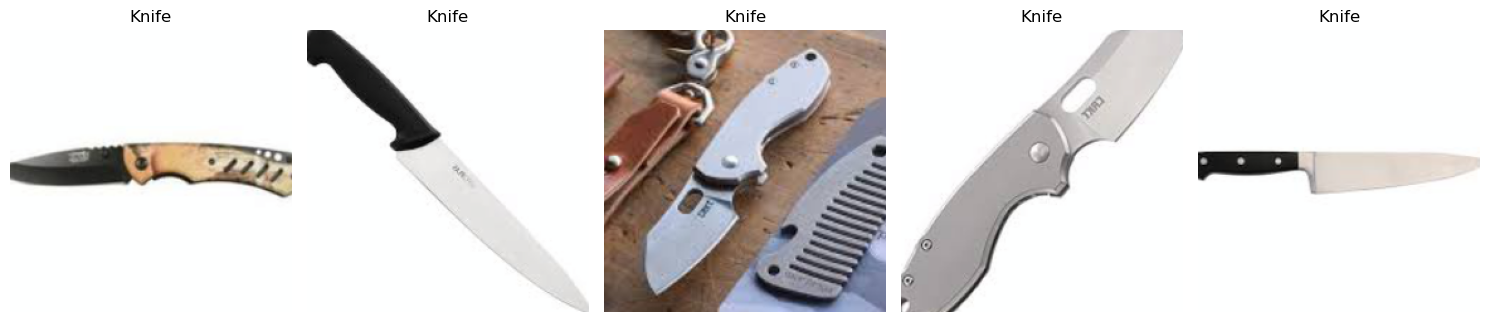

In [8]:
import matplotlib.pyplot as plt

train_loader, test_loader, classes = get_dataloaders()

plt.figure(figsize=(15, 5))
for i in range(5):
    img, label = train_set[i]
    img = img.permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Денормализация
    img = np.clip(img, 0, 1)
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{train_set.classes[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### b. Метрики качества
Для оценки моделей будем использовать метрику *accuracy* 

## 2. Создание бейзлайна

Метод обучения моделей

In [6]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    model.to(device)
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        

        with tqdm(train_loader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                
    
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                optimizer.zero_grad(set_to_none=True)
                

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                

                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                train_loss += loss.item() * inputs.size(0)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
                tepoch.set_postfix(loss=loss.item(), accuracy=100.*correct/total)
        val_loss, val_acc = evaluate(model, test_loader, criterion)
        scheduler.step()
        

        
        print(f'Train Loss: {train_loss/total:.4f} Acc: {100.*correct/total:.2f}% | '
              f'Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%')

Оценка модели

In [7]:
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    losses = []
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        losses.append(loss.item())
    
    return np.mean(losses), 100. * correct / total

### Для сверточной модели мы используем Resnet18, обучаем её

In [9]:
model_cnn = models.resnet18(pretrained=True)
model_cnn.fc = nn.Linear(model_cnn.fc.in_features, len(classes))

optimizer = optim.AdamW(model_cnn.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
train_model(model_cnn, train_loader, test_loader, criterion, optimizer, scheduler)
end_time = time.time()

print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes")
print("Final evaluation:")
final_loss, final_acc = evaluate(model_cnn, test_loader, criterion)
print(f"Final Validation Accuracy: {final_acc:.2f}%")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Epoch 1: 100%|██████████████| 13/13 [00:05<00:00,  2.29batch/s, accuracy=80.8, loss=0.358]


Train Loss: 0.5443 Acc: 80.83% | Val Loss: 0.0000 Acc: 100.00%
Epoch 2/10


Epoch 2: 100%|████████████████| 13/13 [00:02<00:00,  5.19batch/s, accuracy=91, loss=0.258]


Train Loss: 0.2402 Acc: 91.02% | Val Loss: 1.3100 Acc: 64.00%
Epoch 3/10


Epoch 3: 100%|█████████████| 13/13 [00:02<00:00,  5.20batch/s, accuracy=95.4, loss=0.0726]


Train Loss: 0.1138 Acc: 95.39% | Val Loss: 0.0878 Acc: 92.00%
Epoch 4/10


Epoch 4: 100%|██████████████| 13/13 [00:02<00:00,  5.27batch/s, accuracy=96.1, loss=0.729]


Train Loss: 0.1081 Acc: 96.12% | Val Loss: 3.5664 Acc: 68.00%
Epoch 5/10


Epoch 5: 100%|██████████████| 13/13 [00:02<00:00,  5.26batch/s, accuracy=95.1, loss=0.157]


Train Loss: 0.1360 Acc: 95.15% | Val Loss: 0.4512 Acc: 84.00%
Epoch 6/10


Epoch 6: 100%|█████████████| 13/13 [00:02<00:00,  5.18batch/s, accuracy=94.9, loss=0.0146]


Train Loss: 0.1349 Acc: 94.90% | Val Loss: 0.4276 Acc: 88.00%
Epoch 7/10


Epoch 7: 100%|█████████████| 13/13 [00:02<00:00,  5.28batch/s, accuracy=97.3, loss=0.0352]


Train Loss: 0.0861 Acc: 97.33% | Val Loss: 0.3650 Acc: 88.00%
Epoch 8/10


Epoch 8: 100%|███████████████| 13/13 [00:02<00:00,  5.22batch/s, accuracy=99, loss=0.0809]


Train Loss: 0.0324 Acc: 99.03% | Val Loss: 0.1315 Acc: 96.00%
Epoch 9/10


Epoch 9: 100%|██████████████| 13/13 [00:02<00:00,  5.15batch/s, accuracy=100, loss=0.0113]


Train Loss: 0.0178 Acc: 100.00% | Val Loss: 0.1711 Acc: 92.00%
Epoch 10/10


Epoch 10: 100%|███████████| 13/13 [00:02<00:00,  5.22batch/s, accuracy=99.8, loss=0.00444]


Train Loss: 0.0164 Acc: 99.76% | Val Loss: 0.1442 Acc: 96.00%

Training completed in 0.51 minutes
Final evaluation:
Final Validation Accuracy: 96.00%


Итоговый accuracy = 96%. Это очень хороший результат, но нужно учитывать что используется предобученная модель

### В качестве трансформенной модели выбран Vit

In [10]:
model_vit = models.vit_b_16(pretrained=True)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, len(classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vit.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

start_time = time.time()
train_model(model_vit, train_loader, test_loader, criterion, optimizer, scheduler)
end_time = time.time()

print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes")
print("Final evaluation:")
final_loss, final_acc = evaluate(model_vit, test_loader, criterion)
print(f"Final Validation Accuracy: {final_acc:.2f}%")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Epoch 1: 100%|████████████████| 13/13 [00:20<00:00,  1.60s/batch, accuracy=74, loss=0.271]


Train Loss: 0.4067 Acc: 74.03% | Val Loss: 0.4452 Acc: 80.00%
Epoch 2/10


Epoch 2: 100%|█████████████| 13/13 [00:19<00:00,  1.50s/batch, accuracy=98.3, loss=0.0588]


Train Loss: 0.0693 Acc: 98.30% | Val Loss: 0.1116 Acc: 96.00%
Epoch 3/10


Epoch 3: 100%|█████████████| 13/13 [00:19<00:00,  1.47s/batch, accuracy=99.3, loss=0.0138]


Train Loss: 0.0360 Acc: 99.27% | Val Loss: 0.1523 Acc: 96.00%
Epoch 4/10


Epoch 4: 100%|█████████████| 13/13 [00:19<00:00,  1.51s/batch, accuracy=99.8, loss=0.0143]


Train Loss: 0.0259 Acc: 99.76% | Val Loss: 0.1291 Acc: 96.00%
Epoch 5/10


Epoch 5: 100%|██████████████| 13/13 [00:20<00:00,  1.57s/batch, accuracy=100, loss=0.0103]


Train Loss: 0.0183 Acc: 100.00% | Val Loss: 0.0940 Acc: 96.00%
Epoch 6/10


Epoch 6: 100%|████████████| 13/13 [00:20<00:00,  1.59s/batch, accuracy=99.8, loss=0.00404]


Train Loss: 0.0146 Acc: 99.76% | Val Loss: 0.1074 Acc: 96.00%
Epoch 7/10


Epoch 7: 100%|██████████████| 13/13 [00:20<00:00,  1.57s/batch, accuracy=100, loss=0.0163]


Train Loss: 0.0121 Acc: 100.00% | Val Loss: 0.0982 Acc: 96.00%
Epoch 8/10


Epoch 8: 100%|█████████████| 13/13 [00:19<00:00,  1.47s/batch, accuracy=100, loss=0.00843]


Train Loss: 0.0099 Acc: 100.00% | Val Loss: 0.0962 Acc: 96.00%
Epoch 9/10


Epoch 9: 100%|██████████████| 13/13 [00:20<00:00,  1.54s/batch, accuracy=100, loss=0.0082]


Train Loss: 0.0088 Acc: 100.00% | Val Loss: 0.0872 Acc: 96.00%
Epoch 10/10


Epoch 10: 100%|████████████| 13/13 [00:23<00:00,  1.78s/batch, accuracy=100, loss=0.00964]


Train Loss: 0.0093 Acc: 100.00% | Val Loss: 0.0956 Acc: 96.00%

Training completed in 3.47 minutes
Final evaluation:
Final Validation Accuracy: 96.00%


Итоговый accuracy = 96% Трансформенная модель показала точно такую же точность, что и свёрточная

## 3. Улучшение бейзлайна
### Формировние гипотез
- Разнообразим датасеты, используя более разнообразное преобразование изображений.
- Будем случайно поварачивать изображения
- Сделаем их все черно-белые, так как цвет ножа/пистолета не важен при классификации


In [11]:
improved_transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

improved_transforms_test = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_set.transform = improved_transforms_train
test_set.transform = improved_transforms_test

train_loader, test_loader, classes = get_dataloaders()

### Обучение свёрточной модели на улучшенном бейзлайне

In [12]:
model_cnn = models.resnet18(pretrained=True)
model_cnn.fc = nn.Linear(model_cnn.fc.in_features, len(classes))


optimizer = optim.AdamW(model_cnn.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
train_model(model_cnn, train_loader, test_loader, criterion, optimizer, scheduler)
end_time = time.time()

print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes")
print("Final evaluation:")
final_loss, final_acc = evaluate(model_cnn, test_loader, criterion)
print(f"Final Validation Accuracy: {final_acc:.2f}%")

Epoch 1/10


Epoch 1: 100%|████████████████| 13/13 [00:08<00:00,  1.58batch/s, accuracy=84, loss=0.505]


Train Loss: 0.4814 Acc: 83.98% | Val Loss: 0.3657 Acc: 88.00%
Epoch 2/10


Epoch 2: 100%|██████████████| 13/13 [00:04<00:00,  2.83batch/s, accuracy=86.4, loss=0.352]


Train Loss: 0.4487 Acc: 86.41% | Val Loss: 3.6255 Acc: 64.00%
Epoch 3/10


Epoch 3: 100%|██████████████| 13/13 [00:02<00:00,  5.16batch/s, accuracy=86.9, loss=0.407]


Train Loss: 0.3442 Acc: 86.89% | Val Loss: 0.6303 Acc: 64.00%
Epoch 4/10


Epoch 4: 100%|██████████████| 13/13 [00:02<00:00,  5.20batch/s, accuracy=86.2, loss=0.499]


Train Loss: 0.3306 Acc: 86.17% | Val Loss: 0.8860 Acc: 48.00%
Epoch 5/10


Epoch 5: 100%|██████████████| 13/13 [00:02<00:00,  5.20batch/s, accuracy=89.3, loss=0.126]


Train Loss: 0.2926 Acc: 89.32% | Val Loss: 0.1981 Acc: 92.00%
Epoch 6/10


Epoch 6: 100%|████████████████| 13/13 [00:02<00:00,  5.17batch/s, accuracy=92, loss=0.201]


Train Loss: 0.2500 Acc: 91.99% | Val Loss: 0.2902 Acc: 88.00%
Epoch 7/10


Epoch 7: 100%|████████████████| 13/13 [00:02<00:00,  5.19batch/s, accuracy=90, loss=0.135]


Train Loss: 0.2607 Acc: 90.05% | Val Loss: 0.4061 Acc: 84.00%
Epoch 8/10


Epoch 8: 100%|██████████████| 13/13 [00:02<00:00,  5.17batch/s, accuracy=93.2, loss=0.105]


Train Loss: 0.2082 Acc: 93.20% | Val Loss: 0.3893 Acc: 84.00%
Epoch 9/10


Epoch 9: 100%|██████████████| 13/13 [00:02<00:00,  4.93batch/s, accuracy=89.3, loss=0.164]


Train Loss: 0.2893 Acc: 89.32% | Val Loss: 0.3950 Acc: 80.00%
Epoch 10/10


Epoch 10: 100%|█████████████| 13/13 [00:02<00:00,  5.10batch/s, accuracy=90.5, loss=0.387]


Train Loss: 0.2771 Acc: 90.53% | Val Loss: 0.3528 Acc: 84.00%

Training completed in 0.60 minutes
Final evaluation:
Final Validation Accuracy: 84.00%


Точность классификации 84% что хуже обычного бейзлайна.

### Обучение трансформерной модели на улучшенном бейзлайне

In [13]:
model_vit = models.vit_b_16(pretrained=True)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, len(classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vit.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


# Обучение
start_time = time.time()
train_model(model_vit, train_loader, test_loader, criterion, optimizer, scheduler)
end_time = time.time()

print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes")
print("Final evaluation:")
final_loss, final_acc = evaluate(model_vit, test_loader, criterion)
print(f"Final Validation Accuracy: {final_acc:.2f}%")

Epoch 1/10


Epoch 1: 100%|██████████████| 13/13 [00:18<00:00,  1.45s/batch, accuracy=85.7, loss=0.186]


Train Loss: 0.3568 Acc: 85.68% | Val Loss: 0.4118 Acc: 84.00%
Epoch 2/10


Epoch 2: 100%|██████████████| 13/13 [00:18<00:00,  1.45s/batch, accuracy=96.4, loss=0.184]


Train Loss: 0.1228 Acc: 96.36% | Val Loss: 0.1200 Acc: 96.00%
Epoch 3/10


Epoch 3: 100%|█████████████| 13/13 [00:19<00:00,  1.49s/batch, accuracy=96.4, loss=0.0538]


Train Loss: 0.1174 Acc: 96.36% | Val Loss: 0.1643 Acc: 96.00%
Epoch 4/10


Epoch 4: 100%|█████████████| 13/13 [00:19<00:00,  1.46s/batch, accuracy=95.6, loss=0.0827]


Train Loss: 0.1192 Acc: 95.63% | Val Loss: 0.1472 Acc: 92.00%
Epoch 5/10


Epoch 5: 100%|█████████████| 13/13 [00:18<00:00,  1.45s/batch, accuracy=94.7, loss=0.0804]


Train Loss: 0.1487 Acc: 94.66% | Val Loss: 0.1516 Acc: 88.00%
Epoch 6/10


Epoch 6: 100%|████████████████| 13/13 [00:18<00:00,  1.46s/batch, accuracy=92, loss=0.239]


Train Loss: 0.1781 Acc: 91.99% | Val Loss: 0.1809 Acc: 92.00%
Epoch 7/10


Epoch 7: 100%|████████████████| 13/13 [00:19<00:00,  1.46s/batch, accuracy=93, loss=0.157]


Train Loss: 0.1904 Acc: 92.96% | Val Loss: 0.3950 Acc: 84.00%
Epoch 8/10


Epoch 8: 100%|█████████████| 13/13 [00:18<00:00,  1.46s/batch, accuracy=92.7, loss=0.0589]


Train Loss: 0.2200 Acc: 92.72% | Val Loss: 0.2730 Acc: 88.00%
Epoch 9/10


Epoch 9: 100%|████████████████| 13/13 [00:18<00:00,  1.46s/batch, accuracy=91, loss=0.328]


Train Loss: 0.2285 Acc: 91.02% | Val Loss: 0.2349 Acc: 92.00%
Epoch 10/10


Epoch 10: 100%|█████████████| 13/13 [00:18<00:00,  1.46s/batch, accuracy=92.2, loss=0.181]


Train Loss: 0.2068 Acc: 92.23% | Val Loss: 0.2289 Acc: 92.00%

Training completed in 3.25 minutes
Final evaluation:
Final Validation Accuracy: 92.00%


Трансформерная модель на улучшенном бейзлайне также дала хуже результат в 92%

*Обучение моделей на разных бейзлайнах показало, что применённые улучшения не помогли повысить точность классификации и только ухудшили результат, откуда следует что лишение модели информации и попытка её сконцентрировать на других признаках не даёт преимуществ*

## 4. Имплементация моделей

In [14]:
train_set.transform = transform
test_set.transform = transform

train_loader, test_loader, classes = get_dataloaders()

### Создание простой свёрточной сети

In [15]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=37):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x



### Обучение свёрточной сети

In [16]:
custom_cnn = SimpleCNN(num_classes=len(classes)).to(device)
optimizer = optim.AdamW(custom_cnn.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
train_model(custom_cnn, train_loader, test_loader, criterion, optimizer, scheduler)
end_time = time.time()

print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes")
print("Final evaluation:")
final_loss, final_acc = evaluate(custom_cnn, test_loader, criterion)
print(f"Final Validation Accuracy: {final_acc:.2f}%")
     

Epoch 1/10


Epoch 1: 100%|███████████████| 13/13 [00:06<00:00,  1.87batch/s, accuracy=69.4, loss=12.4]


Train Loss: 22.3808 Acc: 69.42% | Val Loss: 48.1174 Acc: 40.00%
Epoch 2/10


Epoch 2: 100%|███████████████| 13/13 [00:02<00:00,  4.61batch/s, accuracy=72.6, loss=4.97]


Train Loss: 8.1122 Acc: 72.57% | Val Loss: 12.1866 Acc: 40.00%
Epoch 3/10


Epoch 3: 100%|███████████████| 13/13 [00:01<00:00,  7.37batch/s, accuracy=80.3, loss=1.68]


Train Loss: 2.0199 Acc: 80.34% | Val Loss: 2.6537 Acc: 64.00%
Epoch 4/10


Epoch 4: 100%|████████████████| 13/13 [00:01<00:00,  7.55batch/s, accuracy=82, loss=0.211]


Train Loss: 0.9791 Acc: 82.04% | Val Loss: 1.4537 Acc: 76.00%
Epoch 5/10


Epoch 5: 100%|██████████████| 13/13 [00:01<00:00,  7.50batch/s, accuracy=78.4, loss=0.573]


Train Loss: 0.4456 Acc: 78.40% | Val Loss: 1.0262 Acc: 52.00%
Epoch 6/10


Epoch 6: 100%|██████████████| 13/13 [00:01<00:00,  7.29batch/s, accuracy=85.9, loss=0.183]


Train Loss: 0.3496 Acc: 85.92% | Val Loss: 0.8654 Acc: 56.00%
Epoch 7/10


Epoch 7: 100%|██████████████| 13/13 [00:01<00:00,  7.51batch/s, accuracy=85.9, loss=0.285]


Train Loss: 0.3322 Acc: 85.92% | Val Loss: 0.8107 Acc: 60.00%
Epoch 8/10


Epoch 8: 100%|██████████████| 13/13 [00:01<00:00,  7.41batch/s, accuracy=87.9, loss=0.266]


Train Loss: 0.3235 Acc: 87.86% | Val Loss: 0.7407 Acc: 56.00%
Epoch 9/10


Epoch 9: 100%|██████████████| 13/13 [00:01<00:00,  7.46batch/s, accuracy=88.3, loss=0.381]


Train Loss: 0.3183 Acc: 88.35% | Val Loss: 0.7624 Acc: 64.00%
Epoch 10/10


Epoch 10: 100%|█████████████| 13/13 [00:01<00:00,  7.15batch/s, accuracy=86.4, loss=0.228]


Train Loss: 0.3169 Acc: 86.41% | Val Loss: 0.7869 Acc: 64.00%

Training completed in 0.44 minutes
Final evaluation:
Final Validation Accuracy: 60.00%


Итоговая точность модели accuracy = 60% что неплохой результат для короткого обучения не предобученной заранее модели.

### Создание своего трансформера

In [17]:
class SimpleViT(nn.Module):
    def __init__(self, num_classes=2, image_size=224, patch_size=16, dim=128):
        super(SimpleViT, self).__init__()
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size * patch_size
        
        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=8), num_layers=3)
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.Linear(dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes))
        
    def forward(self, img):
        p = self.patch_size
        bs, c, h, w = img.shape
        x = img.unfold(2, p, p).unfold(3, p, p)
        x = x.contiguous().view(bs, c, -1, p, p)
        x = x.permute(0, 2, 3, 4, 1).contiguous()
        x = x.view(bs, -1, p*p*c)
        
        x = self.patch_to_embedding(x)
        cls_tokens = self.cls_token.expand(bs, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)



Обучение своего трансформера

In [18]:
custom_vit = SimpleViT(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(custom_vit.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

start_time = time.time()
train_model(custom_vit, train_loader, test_loader, criterion, optimizer, scheduler)
end_time = time.time()

print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes")
print("Final evaluation:")
final_loss, final_acc = evaluate(custom_vit, test_loader, criterion)
print(f"Final Validation Accuracy: {final_acc:.2f}%")
     

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10


Epoch 1: 100%|████████████████| 13/13 [00:06<00:00,  1.95batch/s, accuracy=66, loss=0.349]


Train Loss: 0.6146 Acc: 66.02% | Val Loss: 1.2707 Acc: 40.00%
Epoch 2/10


Epoch 2: 100%|██████████████| 13/13 [00:01<00:00, 11.72batch/s, accuracy=77.7, loss=0.677]


Train Loss: 0.5476 Acc: 77.67% | Val Loss: 1.0370 Acc: 40.00%
Epoch 3/10


Epoch 3: 100%|██████████████| 13/13 [00:01<00:00, 12.17batch/s, accuracy=77.7, loss=0.634]


Train Loss: 0.5307 Acc: 77.67% | Val Loss: 0.9711 Acc: 40.00%
Epoch 4/10


Epoch 4: 100%|██████████████| 13/13 [00:01<00:00, 12.41batch/s, accuracy=77.7, loss=0.649]


Train Loss: 0.5318 Acc: 77.67% | Val Loss: 1.0291 Acc: 40.00%
Epoch 5/10


Epoch 5: 100%|██████████████| 13/13 [00:01<00:00, 12.38batch/s, accuracy=77.7, loss=0.394]


Train Loss: 0.5346 Acc: 77.67% | Val Loss: 1.0033 Acc: 40.00%
Epoch 6/10


Epoch 6: 100%|██████████████| 13/13 [00:01<00:00, 12.36batch/s, accuracy=77.7, loss=0.623]


Train Loss: 0.5365 Acc: 77.67% | Val Loss: 1.0469 Acc: 40.00%
Epoch 7/10


Epoch 7: 100%|██████████████| 13/13 [00:01<00:00, 12.36batch/s, accuracy=77.7, loss=0.566]


Train Loss: 0.5325 Acc: 77.67% | Val Loss: 0.9651 Acc: 40.00%
Epoch 8/10


Epoch 8: 100%|██████████████| 13/13 [00:01<00:00, 12.28batch/s, accuracy=77.7, loss=0.487]


Train Loss: 0.5327 Acc: 77.67% | Val Loss: 0.9651 Acc: 40.00%
Epoch 9/10


Epoch 9: 100%|██████████████| 13/13 [00:01<00:00, 12.27batch/s, accuracy=77.7, loss=0.603]


Train Loss: 0.5307 Acc: 77.67% | Val Loss: 0.9825 Acc: 40.00%
Epoch 10/10


Epoch 10: 100%|███████████████| 13/13 [00:01<00:00, 12.43batch/s, accuracy=77.7, loss=0.6]


Train Loss: 0.5313 Acc: 77.67% | Val Loss: 0.9902 Acc: 40.00%

Training completed in 0.28 minutes
Final evaluation:
Final Validation Accuracy: 40.00%


Итоговая точность 40% что также неплохо для не предобученного трансформера.

### Сравнение с п.2
При сравнении становится понятно, что библиотечные предобученные модели имеют гораздо лучшую точность в 98% по сравнению с моими моделями, у которых точность не превышает 60%

### Применение улучшенного бейзлайна на собственной модели

In [19]:
improved_transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

improved_transforms_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_set.transform = improved_transforms_train
test_set.transform = improved_transforms_test

train_loader, test_loader, classes = get_dataloaders()

### Собственная сверточная модель на улучшенном бейзлайне

In [20]:
custom_cnn = SimpleCNN(num_classes=len(classes)).to(device)
optimizer = optim.AdamW(custom_cnn.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
train_model(custom_cnn, train_loader, test_loader, criterion, optimizer, scheduler)
end_time = time.time()

print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes")
print("Final evaluation:")
final_loss, final_acc = evaluate(custom_cnn, test_loader, criterion)
print(f"Final Validation Accuracy: {final_acc:.2f}%")
     

Epoch 1/10


Epoch 1: 100%|█████████████████| 13/13 [00:06<00:00,  1.99batch/s, accuracy=67, loss=16.6]


Train Loss: 15.5969 Acc: 66.99% | Val Loss: 35.8174 Acc: 40.00%
Epoch 2/10


Epoch 2: 100%|███████████████| 13/13 [00:02<00:00,  5.12batch/s, accuracy=70.4, loss=6.03]


Train Loss: 7.6077 Acc: 70.39% | Val Loss: 15.8872 Acc: 40.00%
Epoch 3/10


Epoch 3: 100%|███████████████| 13/13 [00:01<00:00,  7.54batch/s, accuracy=72.1, loss=2.56]


Train Loss: 4.0174 Acc: 72.09% | Val Loss: 5.6654 Acc: 48.00%
Epoch 4/10


Epoch 4: 100%|██████████████| 13/13 [00:01<00:00,  7.54batch/s, accuracy=70.6, loss=0.775]


Train Loss: 1.9803 Acc: 70.63% | Val Loss: 6.2700 Acc: 48.00%
Epoch 5/10


Epoch 5: 100%|████████████████| 13/13 [00:01<00:00,  7.56batch/s, accuracy=68.4, loss=1.2]


Train Loss: 1.2876 Acc: 68.45% | Val Loss: 3.3151 Acc: 40.00%
Epoch 6/10


Epoch 6: 100%|███████████████| 13/13 [00:01<00:00,  7.60batch/s, accuracy=76.9, loss=1.99]


Train Loss: 0.9520 Acc: 76.94% | Val Loss: 1.7492 Acc: 44.00%
Epoch 7/10


Epoch 7: 100%|██████████████| 13/13 [00:01<00:00,  7.51batch/s, accuracy=77.7, loss=0.645]


Train Loss: 0.7459 Acc: 77.67% | Val Loss: 0.9140 Acc: 56.00%
Epoch 8/10


Epoch 8: 100%|██████████████| 13/13 [00:01<00:00,  7.46batch/s, accuracy=73.5, loss=0.259]


Train Loss: 0.7176 Acc: 73.54% | Val Loss: 0.8629 Acc: 60.00%
Epoch 9/10


Epoch 9: 100%|██████████████| 13/13 [00:01<00:00,  7.49batch/s, accuracy=74.5, loss=0.485]


Train Loss: 0.6472 Acc: 74.51% | Val Loss: 0.9234 Acc: 60.00%
Epoch 10/10


Epoch 10: 100%|█████████████| 13/13 [00:01<00:00,  7.58batch/s, accuracy=75.7, loss=0.459]


Train Loss: 0.5852 Acc: 75.73% | Val Loss: 0.8665 Acc: 64.00%

Training completed in 0.42 minutes
Final evaluation:
Final Validation Accuracy: 64.00%


Итоговая точность модели на улучшенном бейзлайне 64%

### Собственная трансформерная модель на улучшенном бейзлайне

In [21]:
custom_vit = SimpleViT(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(custom_vit.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

start_time = time.time()
train_model(custom_vit, train_loader, test_loader, criterion, optimizer, scheduler)
end_time = time.time()

print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes")
print("Final evaluation:")
final_loss, final_acc = evaluate(custom_vit, test_loader, criterion)
print(f"Final Validation Accuracy: {final_acc:.2f}%")
     

Epoch 1/10


Epoch 1: 100%|███████████████| 13/13 [00:04<00:00,  2.79batch/s, accuracy=59.2, loss=0.53]


Train Loss: 0.6522 Acc: 59.22% | Val Loss: 1.2646 Acc: 40.00%
Epoch 2/10


Epoch 2: 100%|██████████████| 13/13 [00:01<00:00, 12.14batch/s, accuracy=77.7, loss=0.473]


Train Loss: 0.5595 Acc: 77.67% | Val Loss: 1.1082 Acc: 40.00%
Epoch 3/10


Epoch 3: 100%|██████████████| 13/13 [00:01<00:00, 12.21batch/s, accuracy=77.7, loss=0.415]


Train Loss: 0.5379 Acc: 77.67% | Val Loss: 0.9424 Acc: 40.00%
Epoch 4/10


Epoch 4: 100%|██████████████| 13/13 [00:01<00:00, 12.36batch/s, accuracy=77.7, loss=0.805]


Train Loss: 0.5319 Acc: 77.67% | Val Loss: 1.0605 Acc: 40.00%
Epoch 5/10


Epoch 5: 100%|██████████████| 13/13 [00:01<00:00, 12.33batch/s, accuracy=77.7, loss=0.426]


Train Loss: 0.5333 Acc: 77.67% | Val Loss: 1.0255 Acc: 40.00%
Epoch 6/10


Epoch 6: 100%|██████████████| 13/13 [00:01<00:00, 12.41batch/s, accuracy=77.7, loss=0.525]


Train Loss: 0.5335 Acc: 77.67% | Val Loss: 0.9570 Acc: 40.00%
Epoch 7/10


Epoch 7: 100%|██████████████| 13/13 [00:01<00:00, 12.44batch/s, accuracy=77.7, loss=0.392]


Train Loss: 0.5313 Acc: 77.67% | Val Loss: 1.0176 Acc: 40.00%
Epoch 8/10


Epoch 8: 100%|██████████████| 13/13 [00:01<00:00, 12.28batch/s, accuracy=77.7, loss=0.342]


Train Loss: 0.5328 Acc: 77.67% | Val Loss: 1.0260 Acc: 40.00%
Epoch 9/10


Epoch 9: 100%|██████████████| 13/13 [00:01<00:00, 12.40batch/s, accuracy=77.7, loss=0.517]


Train Loss: 0.5309 Acc: 77.67% | Val Loss: 1.0275 Acc: 40.00%
Epoch 10/10


Epoch 10: 100%|█████████████| 13/13 [00:01<00:00, 12.11batch/s, accuracy=77.7, loss=0.563]


Train Loss: 0.5332 Acc: 77.67% | Val Loss: 1.0283 Acc: 40.00%

Training completed in 0.25 minutes
Final evaluation:
Final Validation Accuracy: 40.00%


Итоговая точность модели на улучшенном бейзлайне 40%

## Результаты

Сравним результаты обучения моделей

Модель|Метрики обычного бейзлайна| Метрики улучшенного бейзлайна   |
|---|---|---------------------------------|
|Свёрточный классификатор|max_acc = 0.96| max_acc = 0.84|
|Трансформерный классификатор|max_acc = 0.96 | max_acc = 0.92 |
|Мой свёрточный классификатор|max_acc = 0.62 | max_acc = 0.64  |
|Мой трансформерный классификатор|max_acc = 0.4 | max_acc = 0.4 |

При разных бейзлайнах библиотечные реализации моделей оказывались значительно лучше моих имплементаций